In [3]:
import numpy as np
import matplotlib.pylab as plt
import scipy as sci
import astropy.io.fits as pf
import smooth as sm
%matplotlib inline

In [4]:
def convert_az_alt_to_ha_dec(az,alt,phi):
    x0 = np.cos(np.radians(alt))*np.cos(np.radians(az))
    x1 = np.cos(np.radians(alt))*np.sin(np.radians(az))
    x2 = np.sin(np.radians(alt))

    R = np.matrix([[-np.sin(np.radians(phi)),0,np.cos(np.radians(phi))],[0,-1,0],[np.cos(np.radians(phi)),0,np.sin(np.radians(phi))]])

    x = np.matrix([[x0],[x1],[x2]])

    xp = np.dot(np.transpose(R),x)

    ha = float(np.degrees(np.arctan2(xp[1],xp[0]))) + 360
    dec = float(np.degrees(np.arcsin(xp[2]))) 

    return ha, dec


In [34]:
################### CAS A ######################

Voltz = np.asarray(np.load('Cas_data_last.npz')['vv'])
Voltz = Voltz - np.mean(Voltz)
Timez = np.asarray(np.load('Cas_data_last.npz')['ttt'])
Timez = Timez- Timez[0]
#Voltz = np.load('Cas_data_last.npz')

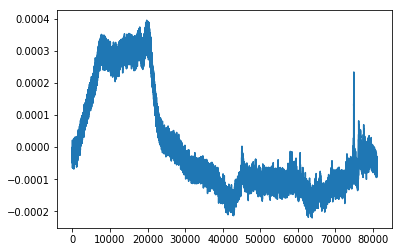

In [35]:
plt.plot(Timez, Voltz)
plt.show()



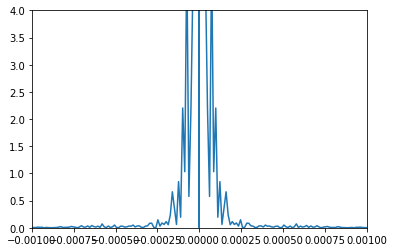

In [36]:
PS = np.abs(np.fft.fft(Voltz))**2
freq = np.fft.fftfreq(len(Timez),d=0.5)

plt.plot(np.fft.fftshift(freq),np.fft.fftshift(PS))
plt.xlim(-0.001, 0.001)
plt.ylim(0,4)
plt.show()


Testing...
Generating simulated experiment
Removing baselines
Plotting results


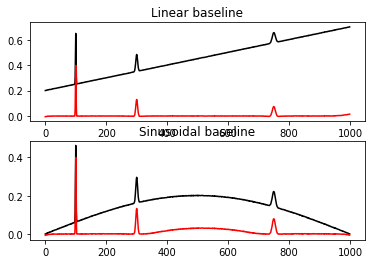

Done!


In [37]:
#By zmzhang https://github.com/zmzhang/airPLS
import numpy as np
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    i=np.arange(0,m)
    E=eye(m,format='csc')
    D=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*D.T*D))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print ('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]
    return z

if __name__=='__main__':
    '''
    Example usage and testing
    '''
    print ('Testing...')
    from scipy.stats import norm
    import matplotlib.pyplot as pl
    x=np.arange(0,1000,1)
    g1=norm(loc = 100, scale = 1.0) # generate three gaussian as a signal
    g2=norm(loc = 300, scale = 3.0)
    g3=norm(loc = 750, scale = 5.0)
    signal=g1.pdf(x)+g2.pdf(x)+g3.pdf(x)
    baseline1=5e-4*x+0.2 # linear baseline
    baseline2=0.2*np.sin(np.pi*x/x.max()) # sinusoidal baseline
    noise=np.random.random(x.shape[0])/500
    print ('Generating simulated experiment')
    y1=signal+baseline1+noise
    y2=signal+baseline2+noise
    print ('Removing baselines')
    c1=y1-airPLS(y1) # corrected values
    c2=y2-airPLS(y2) # with baseline removed
    print ('Plotting results')
    fig,ax=pl.subplots(nrows=2,ncols=1)
    ax[0].plot(x,y1,'-k')
    ax[0].plot(x,c1,'-r')
    ax[0].set_title('Linear baseline')
    ax[1].plot(x,y2,'-k')
    ax[1].plot(x,c2,'-r')
    ax[1].set_title('Sinusoidal baseline')
    pl.show()
    print ('Done!')


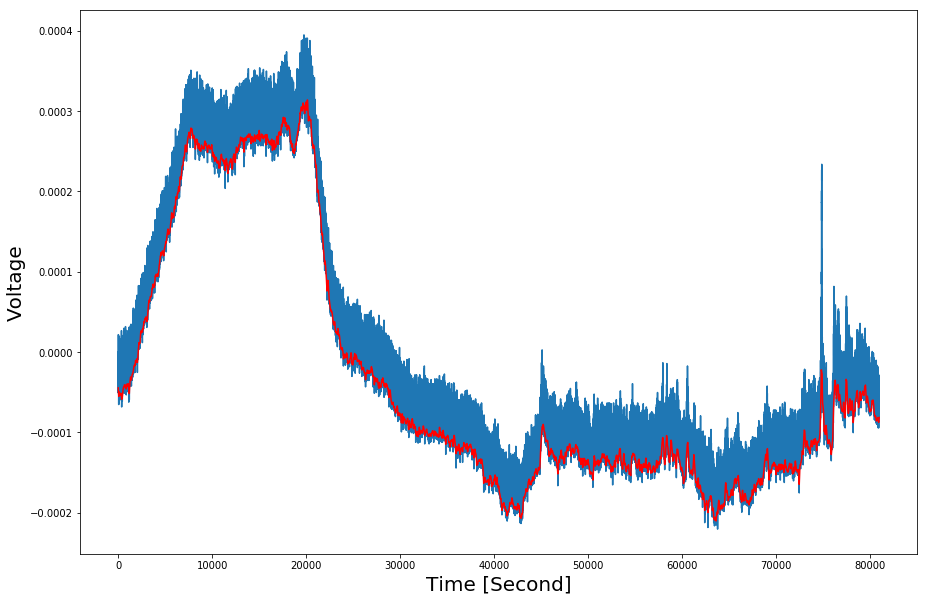

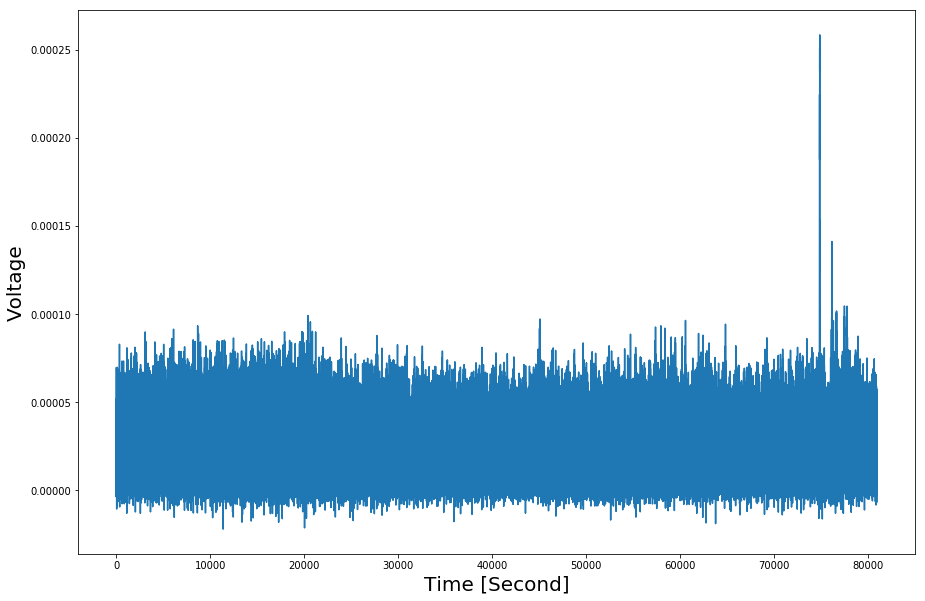

(162032,)


In [47]:
cv = airPLS(Voltz, lambda_=100)
plt.figure(figsize=(15,10))
plt.plot(Timez,Voltz)
plt.plot(Timez, cv, 'r-')
plt.xlabel('Time [Second]', fontsize=20)
plt.ylabel('Voltage', fontsize=20)
plt.show()
bsub = Voltz - cv
plt.figure(figsize=(15,10))
plt.plot(Timez, bsub)
plt.xlabel('Time [Second]', fontsize=20)
plt.ylabel('Voltage', fontsize=20)
#plt.xlim(140000, 155000)
plt.show()

print(cv.shape)

In [39]:
##################### SUN ############################

In [40]:
sun_v = np.load('Sun_data_last.npz')['vv']
sun_t = np.load('Sun_data_last.npz')['ttt'] - 1.521e9

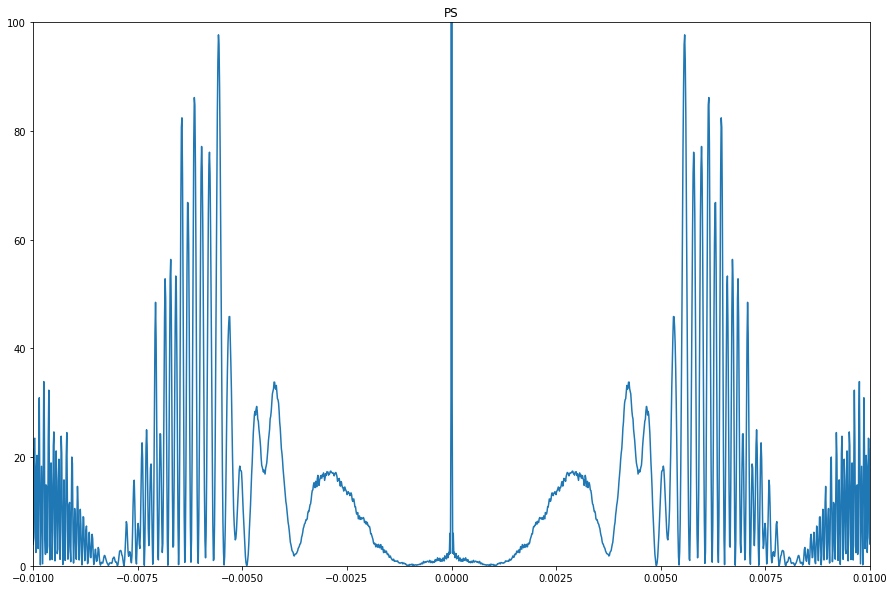

In [41]:
Psun = np.abs(np.fft.fft(sun_v))**2
fsun = np.fft.fftfreq(len(sun_t),0.5)
plt.figure(figsize=(15,10))
plt.plot(np.fft.fftshift(fsun),np.fft.fftshift(Psun))
plt.xlim(-0.01, 0.01)
plt.ylim(0,100)
plt.title('PS')
plt.show()


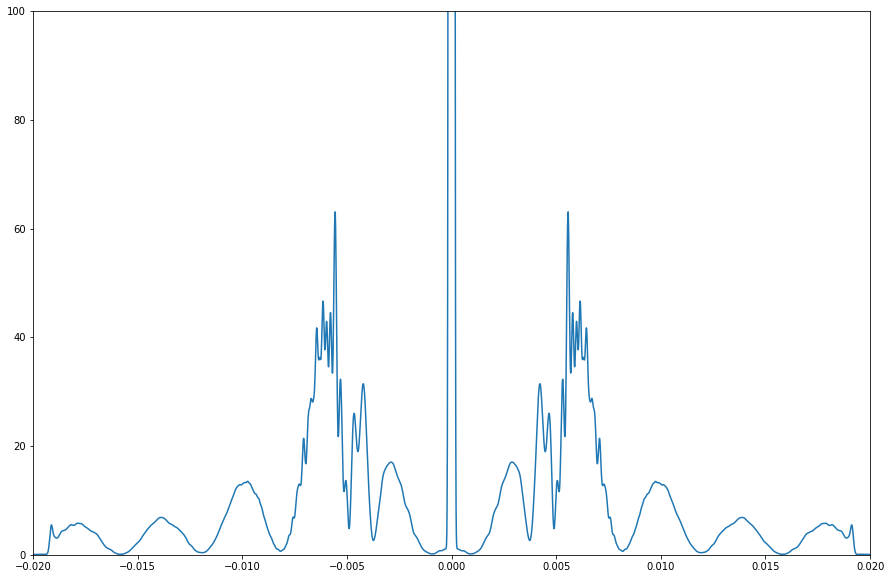

In [42]:
plt.figure(figsize=(15,10))

sv1 = sm.smooth(np.fft.fftshift(Psun))
st1 = sm.smooth(np.fft.fftshift(fsun))
sv2 = sm.smooth(sv1)
st2 = sm.smooth(st1)
sv3 = sm.smooth(sv2)
st3 = sm.smooth(st2)
sv4 = sm.smooth(sv3)
st4 = sm.smooth(st3)
sv5 = sm.smooth(sv4)
st5 = sm.smooth(st4)
sv6 = sm.smooth(sv5)
st6 = sm.smooth(st5)
plt.plot(st6, sv6)
plt.xlim(-0.02, 0.02)
plt.ylim(0,100)
plt.show()


In [43]:
ha = np.array([])
dec = np.array([])
for i in np.arange(2608):
    ha1, dec1 = convert_az_alt_to_ha_dec(az[i], alt[i], Lr)
    ha = np.append(ha, ha1)
    dec = np.append(dec, dec1)
    
B_ew = np.arange(10,30)
Qns = (B_ns/lam * np.sin(L) * np.cos(dec))
Qew = (B_ew/lam * np.cos(dec))

ff = Qew*np.cos(ha) - Qns*np.sin(ha)

NameError: name 'az' is not defined

In [ ]:
#Julian Date	Measured Alt	Measured Az	Correct Alt	Correct Az	westAltitude	westAzimuth	eastAltitude	eastAzimuth

data = np.loadtxt('Cas_coord.txt')

jd = np.array([])
alt = np.array([])
az = np.array([])
c_alt = np.array([])
c_az = np.array([])
alt_w = np.array([])
az_w= np.array([])
alt_e = np.array([])
az_e = np.array([])

for i in np.arange(2608):
    jd1 = data[i][0] #Julian
    alt1 = data[i][1] #Measured Alt
    az1 = data[i][2] #Measured Az
    c_alt1 = data[i][3] #Correct Alt
    c_az1 = data[i][4] #Correct Az
    alt_w1 = data[i][5] #westAltitude
    az_w1 = data[i][6] #westAzimuth
    alt_e1 = data[i][7] #eastAltitude
    az_e1 = data[i][8] #eastAzimuth
    jd = np.append(jd, jd1)
    alt = np.append(alt, alt1)
    az = np.append(az, az1)
    c_alt = np.append(c_alt, c_alt1)
    c_az = np.append(c_az, c_az1)
    alt_w = np.append(alt_w, alt_w1)
    az_w = np.append(az_w, az_w1)
    alt_e = np.append(alt_e, alt_e1)
    az_e = np.append(az_e, az_e1)


In [ ]:
print(jd[0])
print(jd[2607])

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


fig, ax = plt.subplots(figsize=(15,10))

ax.plot(az_w, alt_w, 'r-')
ax.plot(az_e, alt_w, 'b-')
plt.xlabel('Azimuth [Degrees]', fontsize=20)
plt.ylabel('Altitude [Degrees]', fontsize=20)
plt.title('West vs East Antenna', fontsize = 20)
plt.legend(['West Antenna','East Antenna'], fontsize=20)

axins = inset_axes(ax,
                  6.,4,
                  loc = 8,
                  bbox_to_anchor = (-0.13,.15),
                  bbox_transform = ax.figure.transFigure)

mark_inset(ax,
           axins,
           loc1 = 2,
           loc2 = 4,
           ec = "0.3",
           alpha= 0.3)

axins.plot(az_w, alt_w, 'r.-')
axins.plot(az_e, alt_w, 'b.-')
plt.title('Blown Out View', fontsize=20)
axins.set_ylim(53.75,55)
axins.set_xlim(105,106)
plt.show()




In [ ]:
x = np.linspace(100,280)
altfit = np.polyfit(alt_e, alt_w, 1)
azfit = np.polyfit(az_e, az_w, 1)
plt.plot(x, np.polyval(altfit, x))
plt.title('Altitude fit East vs West', fontsize=16)
plt.show()
plt.plot(x, np.polyval(azfit, x))
plt.title('Azimuth fit East vs West', fontsize=16)
plt.show()

print('Altitude Slope = ', altfit[0])
print('Azimuth Slope = ', azfit[0])

$\alpha$ = (RAh $\times $ 15 + $\dfrac{RAm}{4}$ + $\dfrac{RAs}{240}$) $\times$ π/180

$\delta$ = (DEd $\pm$ $\dfrac{DEm}{60}$ $\pm$ $\dfrac{DEs}{3600}$) $\times$ π/180

$E_1(t) = cos(2\pi\nu t)$ Voltage output of antenna 1

$E_2(t) = cos(2\pi\nu [t + \tau_{tot}])$ Voltage output of antenna 2

In [ ]:


B = 20 #meters
B_ew = 20 #Basline EastWest comp
B_ns = 0 #baseline northsouth comp
dec = (22*15 + (0/4) +  (52.1/240))*(np.pi/180) #declination of crab in radian
hs = (5 + (34/60) + (31.95/3600))*(np.pi/180) #Right Acension of crab in radian
c = 3e8 #m/s
lam = 0.0025 #meters
#tau_g = (B_ew/c * np.cos(dec))*np.sin(hs)
L = 37.871853 * np.pi/180 #Terrestrial Latitude in radians
Lr = 37.871853

# v1 = np.cos(np.pi*craby*crabx)
# v2 = np.cos(np.pi*craby*(crabx + tau_tot))

Local Fringe Frequency =

$f_f = [\dfrac{B_{ew}}{\lambda}cos(\delta)]cos(h_{s,0}) - [\dfrac{B_{ns}}{\lambda}sin(L)cos(\delta)]sin(h_{s,0})$

In [ ]:
x = np.array([0,1,2,3,4,5])
y = np.array([0, 0.8, 0.9, 0.1,-0.8,-1])
p1 = sci.polyfit(x,y,1)
p2 = sci.polyfit(x,y,2)
p3 = sci.polyfit(x,y,3)


In [14]:
plt.figure(figsize=(10,5))
plt.plot(x,y, 'o')
xp = np.linspace(-2,6,100)
plt.plot(xp, np.polyval(p1,xp), 'r-')
plt.plot(xp, np.polyval(p2,xp), 'b--')
plt.plot(xp, np.polyval(p3,xp), 'g:')
plt.legend(['Sample Points','1st Degree Fit','2nd Degree Fit','3rd Degree Fit'], fontsize=16)
plt.grid(True)
plt.show()

NameError: name 'y' is not defined

<Figure size 720x360 with 0 Axes>

In [15]:
yfit1 = p1[0]*x + p1[1]
yfit2 = p2[0]*x**2 + p2[1]*x + p2[2] 
yfit3 = p3[0]*x**3 + p3[1]*x**2 + p3[2]*x + p3[3]

print('1st Degree Fit = ', yfit1)
print('2nd Degree Fit = ', yfit2)
print('3rd Degree Fit = ', yfit3)

print('Actual = ', y)

NameError: name 'p1' is not defined

In [16]:
def f(x,m,b):
    return m*x+b

xs = np.array([-2, -1, 0, 1, 2], dtype=np.float)
#ys = np.array([-4.84, -1.03, 1.91, 4.83, 4.79], dtype=np.float)
ys = np.array([-4.0761021 , -0.61376301,  0.96543424,  3.7373177 ,  3.86467818])

def chisq(ys, mdl, sig):
    return np.sum(np.abs(ys-mdl)**2/sig**2)

sig = 1. # assume \sigma_i^2=1
ps = [(1,1),(2,1),(1,2),(2,2)]
chisqs = [chisq(ys, f(xs,*p), sig) for p in ps]
print ('Chi-Square:', chisqs)

Chi-Square: [13.606245099534451, 3.140962559534451, 20.851115079534452, 10.385832539534452]


In [83]:
testimg = pf.getdata('0000.fts')